In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import MakeDataset
from model import SiameseNetwork, ScatteringNetwork

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model import SiameseClassifier

# Running on training dataset

In [3]:
# Load model
scatnet = ScatteringNetwork(theta_div = 5, ds = 4)
model = SiameseNetwork(scatnet)

In [4]:
state_dict = torch.load("siamese-models/siam_v2_final.pth")

In [5]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
dataset = MakeDataset(dataset_type="ieee",mode = "train")

In [19]:
pos_dist_arr = []
neg_dist_arr = []

In [20]:
for i in range(dataset.__len__()):
    (anchor_img, pos_img, neg_img) = dataset.__getitem__(i)
    (H,W) = anchor_img.shape
    anchor_img = torch.reshape(torch.from_numpy(anchor_img), (1,1,H,W))
    pos_img = torch.reshape(torch.from_numpy(pos_img), (1,1,H,W))
    neg_img = torch.reshape(torch.from_numpy(neg_img), (1,1,H,W))

    anchor = model(anchor_img)
    pos = model(pos_img)
    neg = model(neg_img)

    pos_dist = torch.norm(anchor - pos)
    neg_dist = torch.norm(anchor - neg)
    pos_dist_arr.append(pos_dist.item())
    neg_dist_arr.append(neg_dist.item())

In [21]:
pos_dist_arr = np.array(pos_dist_arr)
neg_dist_arr = np.array(neg_dist_arr)

In [23]:
print("mean pos dist: ", np.mean(pos_dist_arr))
print("std pos dist: ", np.std(pos_dist_arr))
print("mean neg dist", np.mean(neg_dist_arr))
print("std neg dist", np.std(neg_dist_arr))

mean pos dist:  4.272645527408237
std pos dist:  1.23637133218063
mean neg dist 5.865790309414031
std neg dist 1.297391340279686


In [6]:
from utils import LabeledPairDataset

In [42]:
true_positives = 0
true_negatives = 0
predicted_positives = 0
predicted_negatives = 0
correct_positives = 0
correct_negatives = 0

In [8]:
paired_dataset = LabeledPairDataset(mode = "train", dataset_type = "ieee")

In [9]:
dataloader = torch.utils.data.DataLoader(paired_dataset,batch_size=10)

In [46]:
for (i, (label, img1, img2)) in enumerate(dataloader):
    (N,H,W) = img1.shape
    img1 = torch.reshape(img1, (N,1,H,W))
    img2 = torch.reshape(img2, (N,1,H,W))
    f1 = model(img1)
    f2 = model(img2)
    dist = torch.flatten(torch.norm(f1 - f2, dim = 1))
    preds = torch.lt(dist, 5.0*torch.ones(N)).to(torch.float)
    
    true_positives += torch.sum(label)
    predicted_positives += torch.sum(preds)
    correct_positives += torch.sum(torch.mul(label, preds))

    true_negatives += N - torch.sum(label)
    predicted_negatives += N - torch.sum(preds)
    correct_negatives += torch.sum(torch.mul(1 - label, 1 - preds))

In [47]:
print("Overall accuracy: ", (correct_negatives+correct_positives)/(true_negatives+true_positives))
print("Percentage of : ", correct_positives/true_positives)
print("Negatives accuracy: ", correct_negatives/true_negatives)

Accuracy:  tensor(0.7785, dtype=torch.float64)
Positives accuracy:  tensor(0.7776, dtype=torch.float64)
Negatives accuracy:  tensor(0.7789, dtype=torch.float64)


In [55]:
# Create confusion matrix
cm = np.array([[correct_positives.item(), (true_positives - correct_positives).item()],[(true_negatives - correct_negatives).item(), correct_negatives.item()]], dtype = np.int32)

In [49]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x23a684561c0>,
 [Text(0, 0, 'Predicted positives'), Text(1, 0, 'Predicted negatives')])

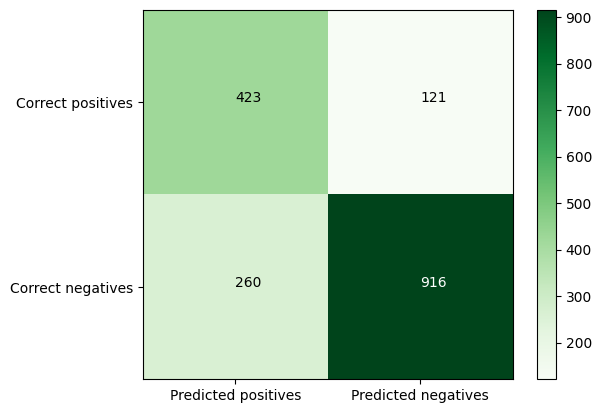

In [69]:
plt.imshow(cm, cmap = "Greens")
plt.colorbar()
plt.text(0,0,cm[0,0])
plt.text(1,0,cm[0,1])
plt.text(0,1,cm[1,0])
plt.text(1,1,cm[1,1], color = "white")
plt.yticks([0,1],["Correct positives", "Correct negatives"])
plt.xticks([0,1],["Predicted positives", "Predicted negatives"])

In [13]:
print("Accuracy: ", (correct_negatives+correct_positives)/(true_negatives+true_positives))
print("Positives accuracy: ", correct_positives/true_positives)
print("Negatives accuracy: ", correct_negatives/true_negatives)

Accuracy:  tensor(0.7012, dtype=torch.float64)
Positives accuracy:  tensor(0.8510, dtype=torch.float64)
Negatives accuracy:  tensor(0.6359, dtype=torch.float64)


# Results on test dataset

In [71]:
test_paired_dataset = LabeledPairDataset(mode = "test", dataset_type = "ieee") 

In [78]:
test_dataloader = torch.utils.data.DataLoader(test_paired_dataset,batch_size=10, shuffle=True)

In [83]:
test_true_positives = 0
test_true_negatives = 0
test_predicted_positives = 0
test_predicted_negatives = 0
test_correct_positives = 0
test_correct_negatives = 0

In [84]:
for (i, (label, img1, img2)) in enumerate(test_dataloader):
    (N,H,W) = img1.shape
    img1 = torch.reshape(img1, (N,1,H,W))
    img2 = torch.reshape(img2, (N,1,H,W))
    f1 = model(img1)
    f2 = model(img2)
    dist = torch.flatten(torch.norm(f1 - f2, dim = 1))
    preds = torch.lt(dist, 5.2*torch.ones(N)).to(torch.float)
    
    test_true_positives += torch.sum(label)
    test_predicted_positives += torch.sum(preds)
    test_correct_positives += torch.sum(torch.mul(label, preds))

    test_true_negatives += N - torch.sum(label)
    test_predicted_negatives += N - torch.sum(preds)
    test_correct_negatives += torch.sum(torch.mul(1 - label, 1 - preds))
    if i==5: break

In [85]:
# Create confusion matrix
test_cm = np.array([[test_correct_positives.item(), (test_true_positives - test_correct_positives).item()],[(test_true_negatives - test_correct_negatives).item(), test_correct_negatives.item()]], dtype = np.int32)

([<matplotlib.axis.XTick at 0x23a03f731c0>,
 [Text(0, 0, 'Predicted positives'), Text(1, 0, 'Predicted negatives')])

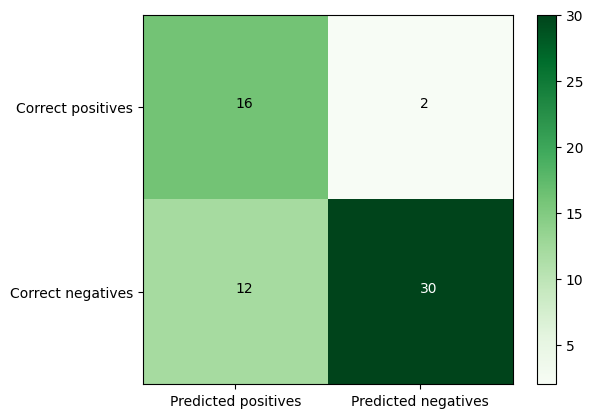

In [86]:
plt.imshow(test_cm, cmap = "Greens")
plt.colorbar()
plt.text(0,0,test_cm[0,0])
plt.text(1,0,test_cm[0,1])
plt.text(0,1,test_cm[1,0])
plt.text(1,1,test_cm[1,1], color = "white")
plt.yticks([0,1],["Correct positives", "Correct negatives"])
plt.xticks([0,1],["Predicted positives", "Predicted negatives"])